In [1]:
import sys
sys.path.append("./tacotron2/") # go to parent dir
# from customFunctions import *
sys.path.append("./waveglow/")

In [2]:
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

In [20]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', 
                       interpolation='none')

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.training_files = './tacotron2/filelists/vlsp/train.txt'

attention_dim: 128
attention_location_kernel_size: 31
attention_location_n_filters: 32
attention_rnn_dim: 1024
batch_size: 16
cudnn_benchmark: false
cudnn_enabled: true
decoder_rnn_dim: 1024
dist_backend: nccl
dist_url: tcp://localhost:54321
distributed_run: false
dynamic_loss_scaling: true
encoder_embedding_dim: 512
encoder_kernel_size: 5
encoder_n_convolutions: 3
epochs: 37
filter_length: 1024
fp16_run: false
gate_threshold: 0.5
grad_clip_thresh: 1.0
hop_length: 256
ignore_layers:
- embedding.weight
iters_per_checkpoint: 200
learning_rate: 0.001
load_mel_from_disk: false
mask_padding: true
max_decoder_steps: 1000
max_wav_value: 32768.0
mel_fmax: 8000.0
mel_fmin: 0.0
n_frames_per_step: 1
n_mel_channels: 80
n_symbols: 150
p_attention_dropout: 0.1
p_decoder_dropout: 0.1
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5
prenet_dim: 256
sampling_rate: 22050
seed: 1234
symbols_embedding_dim: 512
text_cleaners:
- flowtron_cleaners
training_files: filelists/vlsp/tra

In [5]:
checkpoint_path = "./tacotron2/checkpoints/checkpoint_30119"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [6]:
from waveglow.denoiser import Denoiser
waveglow_path = './waveglow/checkpoints/waveglow_9821'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [7]:
from data_utils import TextMelLoader, TextMelCollate
trainset = TextMelLoader(hparams.training_files, hparams)

In [38]:
textx = "người ta thường hay nghĩ quá đáng * ngay cả trong trường hợp và bờ lô"


In [39]:
inputs=trainset.get_text(
    textx
)
sequence = torch.autograd.Variable(
    inputs.unsqueeze(0)).cuda().long()
sequence.size()
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

Warning! Reached max decoder steps


In [40]:
sequence

tensor([[51, 40, 81, 66, 42,  0, 74,  6,  0, 74, 41, 81, 66, 51, 40,  0, 41,  6,
         89,  0, 51, 40, 41, 46,  0, 71, 75,  7,  0, 27,  7, 51, 40,  0,  4,  0,
         51, 40,  6, 89,  0, 25, 11,  0, 74, 72, 52, 51, 40,  0, 74, 72, 81, 66,
         51, 40,  0, 41, 67, 70,  0, 87,  8,  0, 24, 66,  0, 49, 58]],
       device='cuda:0')

In [41]:
# mel_outputs, mel_outputs_postnet, _, alignments

In [42]:
# trainset.text_embedding.symbol2numeric_dict

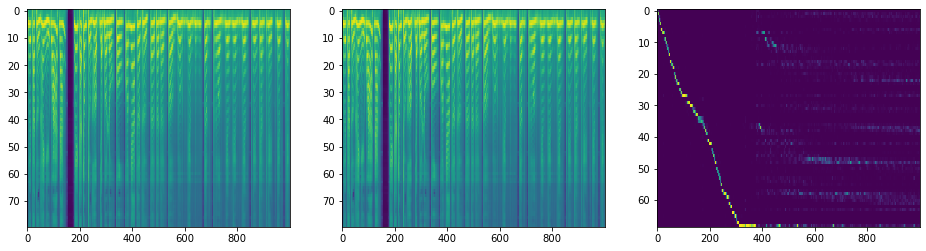

In [43]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [44]:
mel_outputs_postnet

tensor([[[ -8.6484,  -6.6445,  -5.0195,  ...,  -4.2930,  -3.8398,  -3.6387],
         [ -8.8047,  -7.0469,  -4.8906,  ...,  -4.1875,  -3.7207,  -3.4785],
         [ -9.3047,  -7.2227,  -4.6016,  ...,  -3.9375,  -3.5059,  -3.3066],
         ...,
         [-11.0625,  -9.9297,  -8.4375,  ...,  -7.2773,  -7.0078,  -7.0742],
         [-11.1328, -10.1172,  -8.2891,  ...,  -7.1797,  -6.9961,  -7.0000],
         [-11.1562,  -9.9141,  -8.1328,  ...,  -7.1641,  -6.9258,  -6.9453]]],
       device='cuda:0', dtype=torch.float16)

In [48]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet,sigma=0.666)


In [49]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [50]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
mel_outputs_postnet

In [16]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [ ]:
z.unsqueeze(0).float().to("cuda")

In [ ]:
z -mel_outputs_postnet.squeeze(0)

In [ ]:
mel_outputs_postnet.size(),z.size()

In [ ]:
torch.mean(mel_outputs_postnet[0,:,:341].cpu() - z.cpu())